# Characteristics of a CCD: Image Reduction

This notebook carries out the cleaning, calibration and analysis of the data taken at the observatory 

## Setup

The following two code cells import the material you will need for this lab: first the Python 3 modules and packages, and then the data files. You only need to do these steps once. 

Run these cells without editing them. Reminder: run (execute) cells with *SHIFT*-*ENTER*. This works for both code and markdown cells. 

### IMPORTANT Check that you have adequate disk space in your Syzygy home dir before you download the data. Ask your TA for help regarding this, if you are unsure how to do this. 
### IF YOU EXCEED YOUR DISK QUOTA, YOU WILL BE LOCKED OUT OF SYZYGY!

### Import Python modules and packages


In [2]:
# common/useful python packages
import numpy as np
import matplotlib.pyplot as plt
import os

# package to read and interpret fits files
import astropy.io.fits as pyfits
from astropy.stats import sigma_clipped_stats

# photometry packages
import photutils

# helper packages for accessing data 
import urllib, zipfile, tarfile, glob
from urllib.request import urlretrieve
import warnings

## uncomment and run the following command once to test photutils
## photutils.test()

## plotting packages
import matplotlib.pyplot as plt
import matplotlib.pylab as plab
from astropy.visualization import astropy_mpl_style
from astropy.visualization import simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
plt.style.use(astropy_mpl_style)
from skimage import data, img_as_float
from skimage import exposure


### Load Data

In [3]:
# Check if data dir exists. If not, retrieve data from UVic website.
# Data is retrieved as a tarball and untarred in your home directory.

datadir = 'CCDlab_data'

if not(os.path.exists(datadir) and os.path.isdir(datadir)):
    url = 'http://astrowww.phys.uvic.ca/~astrolab/AstroLabs/A250/CCDlab/'
    tgz = datadir+'.tgz'
    urlretrieve(url+tgz, filename=tgz)
    tar = tarfile.open(tgz)
    tar.extractall()
    tar.close()

# Print out details
print('Lab data directory: '+datadir)
print('List of available files:')
file_list = os.listdir(datadir)
for file in file_list:
    print(file)    

# ignore any warnings (they are mostly due to unexpected 
# formatting in the fits files' headers)
warnings.filterwarnings('ignore', category=UserWarning, append=True)

Lab data directory: CCDlab_data
List of available files:
pflat-64.SPE.fits
flat-01.SPE.fits
pflat-512.SPE.fits
pflat-128.SPE.fits
masterFLAT.fits
flat-16.SPE.fits
masterBIAS.fits
dark-1800s.fits
pflat-04.SPE.fits
pflat-02.SPE.fits
pflat-1024.SPE.fits
flat-128.SPE.fits
flat-512.SPE.fits
pflat-32.SPE.fits
flat-08.SPE.fits
pflat-2048.SPE.fits
flat-256.SPE.fits
flat-04.SPE.fits
pflat-16.SPE.fits
pflat-01.SPE.fits
flat-64.SPE.fits
pflat-256.SPE.fits
flat-2048.SPE.fits
pflat-08.SPE.fits
flat-32.SPE.fits
flat-02.SPE.fits
flat-1024.SPE.fits


# Data Analysis

The analysis process is outlined in your manual's procedure. Refer to it as a road map as you work through the remainder of this notebook.

## STEP 0: Gather File Metadata

The files above (in *file\_list*) are listed in random order. You may find it helpful to look in the data directory itself, which has been created in your account as *CCDLab\_data*, and lists the files in alphabetical order.

All of these files are *fits files*, which is a data format that includes a header containing useful information about the image. 

**File Name Conventions**

  1. The raw (unprocessed) images are named *flat-\*\*.SPE.fits*.
  2. *masterBias.fits* is the bias image.
  3. *masterFlat.fits* is the flat field image.
  4. *dark-1800s.fits* is the dark image.


#### Accessing data and getting basic info.

The first step is to access the data files (images) and print out some basic information about them. The following cells introduce how to do this.

The next cell loads a sample file, *flat-01.SPE.fits*, and retrieves some basic information about it.  The information is retrieved using the function *info* from the package *astropy.io.fits,* which we have imported under the name *pyfits*.

In [4]:
# create a path to the file
filename = 'flat-32.SPE.fits'
fits_path = datadir + '/' + filename

# get file info
pyfits.info(fits_path)

Filename: CCDlab_data/flat-32.SPE.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      13   (2048, 2048)   int16   


**Exercise:** Try changing the filename in the above cell. Do you get the same kind of information?

We will now learn to access the *fits header*, which contains important information such as the image size and exposure time.

In [5]:
# read header for the file from the previous cell
header = pyfits.getheader(fits_path,ext=0)

# get a few pieces of information
naxis1 = header['NAXIS1'] # x-dimension 
naxis2 = header['NAXIS2'] # y-dimension
etime = header['EXPTIME'] # exposure time

# print results
print('Filename       X-size  Y-size  Exp Time[s]')
print('%s %7d %7d %9.1f' % (filename,naxis1,naxis2,etime))

Filename       X-size  Y-size  Exp Time[s]
flat-32.SPE.fits    2048    2048       3.2


#### Get header information for all of the raw observations. 

In the following cell, create a list of the raw files' names, then get the x,y sizes and exposure times for each. Print your results as you go.

The code to create a file list is provided as an example. Fill in the rest of the cell yourself.  

In [6]:
# list of file names (raw images only)
# you could type them all by hand, but this is faster:
raw_file_list = glob.glob(datadir + '/' +'flat-*.SPE.fits')

# print heading for results    
print('    Filename                    X-size  Y-size  Exp Time[s]')

# get the sizes and exposure times for all the files in the list:
for filename in raw_file_list:
    header = pyfits.getheader(filename,ext=0)
    naxis1 = header['NAXIS1']
    naxis2 = header['NAXIS2']
    etime = header['EXPTIME'] 
    print('%-30s %7d %7d %9.1f' % (filename,naxis1,naxis2,etime))


    Filename                    X-size  Y-size  Exp Time[s]
CCDlab_data/flat-01.SPE.fits      2048    2048       0.1
CCDlab_data/flat-16.SPE.fits      2048    2048       1.6
CCDlab_data/flat-128.SPE.fits     2048    2048      12.8
CCDlab_data/flat-512.SPE.fits     2048    2048      51.2
CCDlab_data/flat-08.SPE.fits      2048    2048       0.8
CCDlab_data/flat-256.SPE.fits     2048    2048      25.6
CCDlab_data/flat-04.SPE.fits      2048    2048       0.4
CCDlab_data/flat-64.SPE.fits      2048    2048       6.4
CCDlab_data/flat-2048.SPE.fits    2048    2048     204.8
CCDlab_data/flat-32.SPE.fits      2048    2048       3.2
CCDlab_data/flat-02.SPE.fits      2048    2048       0.2
CCDlab_data/flat-1024.SPE.fits    2048    2048     102.4


## **Dark frame and cosmic rays**

We will first inspect a dark frame to see the effect of *hot* pixels. At the same, we will also estimate the number of cosimic ray strikes on the CCD.

Exposure time of dark frame[s]: 1800.0

Sig clipped mean, med and sdev: 448.6 454.0 32.2

Total number of pixels in CCD: 4194304

Number of hot pixels in CCD (10-50 sigma): 4254

Number of CR strikes in CCD (> 50 sigma): 1514



Text(0.5, 1.0, 'CR strikes in sub-region (> 50 sigma above mean)')

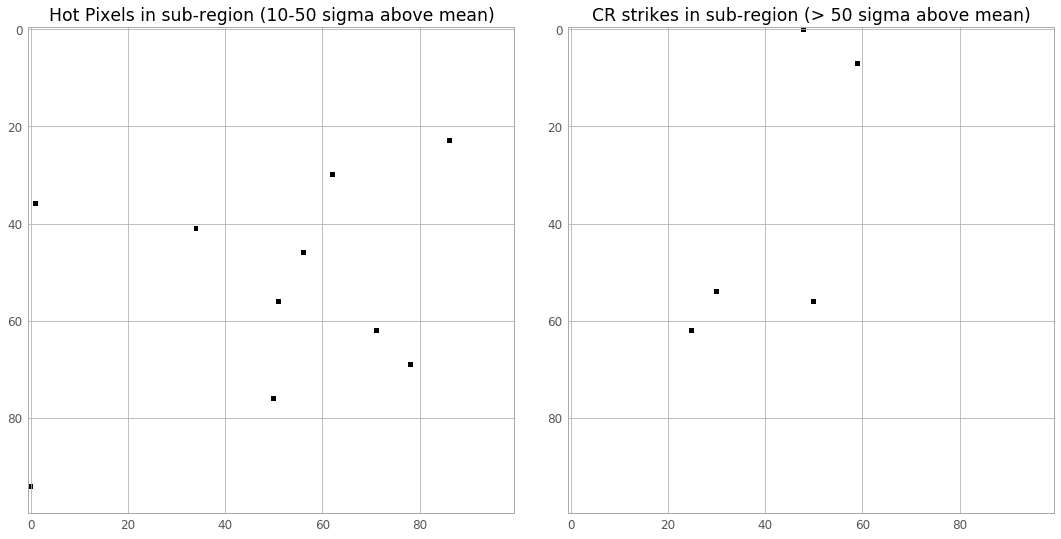

In [7]:
# Read in the dark frame
filename = 'dark-1800s.fits'
fits_path = datadir + '/' + filename

# read data into array
dark_data = pyfits.getdata(fits_path,ext=0)
dark_header = pyfits.getheader(fits_path, ext=0)

# get the x,y size 
array_size = dark_data.shape
etime = dark_header['EXPOSURE']
naxis1 = dark_header['NAXIS1']
naxis2 = dark_header['NAXIS2']
print('Exposure time of dark frame[s]: %.1f\n' % etime)

# compute the sigma clipped mean and std dev
sc_mean, sc_median, sc_stddev = sigma_clipped_stats(dark_data, sigma=5.0, maxiters=5)
print('Sig clipped mean, med and sdev: %.1f %.1f %.1f\n' % (sc_mean, sc_median, sc_stddev))

# Pixels which are 10 - 50 sigma above the mean are 'hot' pixels
# hotpix = zeros(naxis1,naxis2)
low_cond = sc_mean + 10.*sc_stddev
hi_cond = sc_mean + 50.*sc_stddev
hotpix = np.where(((dark_data >= low_cond) & (dark_data < hi_cond)),1,0)
# cosmic ray strikes are 50 sigma above the mean 
cr_cond = sc_mean + 50.*sc_stddev
CRpix = np.where((dark_data >= cr_cond),1,0)

# Print out the numbers of pixels
print('Total number of pixels in CCD: %d\n' % np.multiply(naxis1,naxis2))
print('Number of hot pixels in CCD (10-50 sigma): %d\n' % np.sum(hotpix))
print('Number of CR strikes in CCD (> 50 sigma): %d\n' % np.sum(CRpix))

# SCALE AND DISPLAY THE RED IMAGE, and choose an appropriate sub-region for statistics
# set up the figure environment
fig = plt.figure(figsize=(15,15))
# show hot pixels
ax1 = fig.add_axes([0.05, 0.05, 0.45, 0.9])
ax1.imshow(hotpix[1750:1850,330:430], cmap='gray_r')
ax1.set_title('Hot Pixels in sub-region (10-50 sigma above mean)')
# show CR strikes
ax2 = fig.add_axes([0.55, 0.05, 0.45, 0.9])
ax2.imshow(CRpix[1750:1850,330:430], cmap='gray_r')
ax2.set_title('CR strikes in sub-region (> 50 sigma above mean)')


## **Question 1:**


Do you see any cosmic ray hits in your dark frame? These will appear as one- or two-pixel bright spots. How many do you see? Based on the exposure time used for the dark frame, how many hits per second is this?

#### (**TYPE YOUR ANSWER HERE**)
The cosmic rays interacted with the CCD. There were 5 hits that appeared in the dark frame.

## STEP 1: Read in an image

Before we can process an image, it needs to be read into a numerical array. Then we can carry out arithmetic and statistical operations on it. 

The following cell reads an image, converting it to an array, and prints out some basic information about it. 

Try changing *flat-01.SPE.fits* to one of the other files. 

In [8]:
# create a path to the file
filename = 'flat-01.SPE.fits'
fits_path = datadir + '/' + filename

# read data into array
image_data = pyfits.getdata(fits_path,ext=0)

# get the x,y size 
array_size = image_data.shape

# print out the information
print('Image Name: '+fits_path)
print('Image array size: '+str(array_size))

# print with fancy formatting
print('Number of rows: %d' %(array_size[0]))
print('Number of columns: %d' %(array_size[1]))

Image Name: CCDlab_data/flat-01.SPE.fits
Image array size: (2048, 2048)
Number of rows: 2048
Number of columns: 2048


## STEP 2: Bias Subtraction and Flat Fielding

Now that the image data is held as an array, we can do mathematical operations on it. 

Steps: 

  1. **Subtract the *bias* from each image.**
  2. **Divide each image by the *flat field*.**
  
Refer to your manual for the reasoning behind these steps.

#### Processing a single raw image:

In [9]:
# read in the bias and flat
bias_image = datadir + '/masterBIAS.fits'
bias_data = pyfits.getdata(bias_image,ext=0)
flat_image = datadir + '/masterFLAT.fits'
flat_data = pyfits.getdata(flat_image,ext=0)

# prepare a raw image for processing
raw_image = 'flat-01.SPE.fits'
fits_path = datadir + '/' + raw_image
image_data = pyfits.getdata(fits_path, ext=0)
image_header = pyfits.getheader(fits_path, ext=0)

# subtract the bias, then divide by the flat
image_data_b = image_data - bias_data
image_data_f = image_data_b / flat_data
# round pixel values to nearest integer
image_data_f = np.rint(image_data_f)

# save the resulting image with a new name
out_name = 'p'+raw_image # 'p' stands for 'processed'
out_path = datadir + '/' + out_name
pyfits.writeto(out_path,image_data_f,header=image_header,overwrite=True)

# print out file names
print('processed image: '+fits_path)
print('output image: '+out_path)

processed image: CCDlab_data/flat-01.SPE.fits
output image: CCDlab_data/pflat-01.SPE.fits


#### Processing multiple images using a user defined function:

Processing one image at a time is very tedious! We can define a simple function to do this for us. (We could also just put all the analysis in a loop, but making functions is easy and good practice.)

The function is provided for you. Read through the code and understand how it works

In [10]:
def image_processor(file_path,bias_data,flat_data):
    
    # get filename and input dir
    indir,filename = os.path.split(file_path)
    
    # read in the image
    image_data = pyfits.getdata(file_path, ext=0)
    image_header = pyfits.getheader(file_path, ext=0)
    
    # subtract the bias, then divide by the flat
    image_data_b = image_data - bias_data
    image_data_f = image_data_b / flat_data #Because there are different amounts of electrons
    # round pixel values to nearest integer
    image_data_f = np.rint(image_data_f)

    # save the resulting image with a new name
    # We will just add a 'p' in front of the filename
    # to indicate processed
    out_name = 'p'+filename
    out_path = indir + '/' + out_name
    pyfits.writeto(out_path,image_data_f,header=image_header,overwrite=True)
    
    return out_name
    

#### Run the function:

Loop over all the raw files, processing them with our function. The function returns the name of the processed files; we will add these names to a reference list. 

In [11]:
processed_images = []

for file_path in raw_file_list:
    out_name = image_processor(file_path,bias_data,flat_data)
    print('processed %s >> %s' %(file_path,out_name))
    processed_images.append(out_name)

processed CCDlab_data/flat-01.SPE.fits >> pflat-01.SPE.fits
processed CCDlab_data/flat-16.SPE.fits >> pflat-16.SPE.fits
processed CCDlab_data/flat-128.SPE.fits >> pflat-128.SPE.fits
processed CCDlab_data/flat-512.SPE.fits >> pflat-512.SPE.fits
processed CCDlab_data/flat-08.SPE.fits >> pflat-08.SPE.fits
processed CCDlab_data/flat-256.SPE.fits >> pflat-256.SPE.fits
processed CCDlab_data/flat-04.SPE.fits >> pflat-04.SPE.fits
processed CCDlab_data/flat-64.SPE.fits >> pflat-64.SPE.fits
processed CCDlab_data/flat-2048.SPE.fits >> pflat-2048.SPE.fits
processed CCDlab_data/flat-32.SPE.fits >> pflat-32.SPE.fits
processed CCDlab_data/flat-02.SPE.fits >> pflat-02.SPE.fits
processed CCDlab_data/flat-1024.SPE.fits >> pflat-1024.SPE.fits


## STEP 3: Get statistics of processed images.

For each image, we would like to know the exposure time (aka integration time) and the mean and standard deviation of the counts in the image. Exposure time can be read from the header, and the mean and standard deviation will be measured from a sub-region of the images (known as *image slicing*). 

In [12]:
# create lists to hold the output values
etime_list = []
mean_list = []
std_list = []

for filename in processed_images:
    
    fits_path = datadir + '/' + filename
    image_data = pyfits.getdata(fits_path, ext=0)
    image_header = pyfits.getheader(fits_path, ext=0)
    
    etime = image_header['EXPTIME'] # exposure, aka integration, time from header
    region = image_data[100:120,100:120] # a small portion of the image
    mean = np.mean(region)
    std = np.std(region)
    
    etime_list.append(etime)
    mean_list.append(mean)
    std_list.append(std)
    
# let's sort by increasing exp time before printing
sort_indx = np.argsort(etime_list)

# sort all variables by these sorted indices
processed_images = np.array(processed_images)
etime_list = np.array(etime_list)
mean_list = np.array(mean_list)
std_list = np.array(std_list)

processed_images = processed_images[sort_indx]
etime_list = etime_list[sort_indx]
mean_list = mean_list[sort_indx]
std_list = std_list[sort_indx]

# print out the values
nfiles = processed_images.size
print('Statistics of processed images:')
# print('%13s %8s %8s %8s' %('Image Name', 'e-time', 'mean', "std"))
print('     Image Name      e-time      mean       std')
for n in range(nfiles):
    print('%13s %8.1f     %8.3f   %8.3f' %(processed_images[n],etime_list[n],mean_list[n],std_list[n]))
    

Statistics of processed images:
     Image Name      e-time      mean       std
pflat-01.SPE.fits      0.1       46.358      3.868
pflat-02.SPE.fits      0.2      106.188      5.947
pflat-04.SPE.fits      0.4      200.548      7.604
pflat-08.SPE.fits      0.8      406.235     11.435
pflat-16.SPE.fits      1.6      779.140     15.390
pflat-32.SPE.fits      3.2     1791.525     23.719
pflat-64.SPE.fits      6.4     2864.222     32.128
pflat-128.SPE.fits     12.8     6537.502     52.136
pflat-256.SPE.fits     25.6     11979.090     83.415
pflat-512.SPE.fits     51.2     25755.943    153.256
pflat-1024.SPE.fits    102.4     48042.970    286.263
pflat-2048.SPE.fits    204.8     59233.387   1026.710


## STEP 4: Test the linearity of the CCD

How linear is the CCD's response to light? Plot the mean number of counts (y-axis) as a function of exposure time (x-axis). Use a log-log plot.

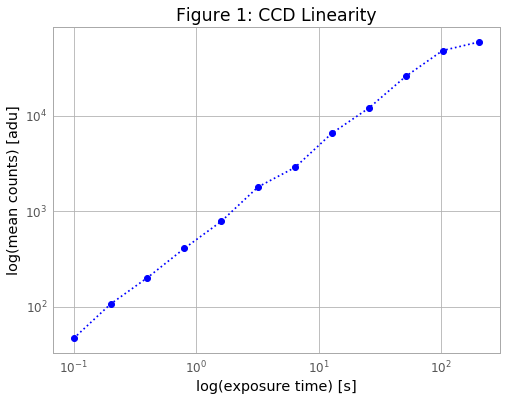

In [13]:
# set up figure
plt.figure()
plt.title('Figure 1: CCD Linearity')
plt.xlabel('log(exposure time) [s]')
plt.ylabel('log(mean counts) [adu]')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)

# plot data
plt.plot(etime_list,mean_list,'bo:')

## **Question 2:**
#### **Based on the given questions, describe the linear behaviour of the CCD**

Is the graph linear? Where and why does this linearity break down? What is the slope of this line? What does the slope tell you?

The graph might be a bit curved in the middle as can be seen, but the general shape of it is linear. The slope represents a 1:1 ratio between the photons entering the CCD and those being created. This slope should be √1/2, which corresponds to S/N = √t from Eqn 4.3 in the lab manual.

## Step 5: Determine the gain of the CCD

We will plot the mean number of counts (x-axis) versus the variance (y-axis). After plotting, use the linear part to find the gain (use images with longer exposure times, but without saturation).

## IMPORTANT: In the plot above, we notice the trend levels off which is due to saturation. Therefore, for the remaining part of the lab, we will not use those points

#### EXERCISE: LOOK AT THE PLOT, AND DECIDE HOW MANY POINTS YOU WISH TO TRIM

In [14]:
# Trim off the last six points
mu_vect = mean_list[:-6]
sdev_vect = std_list[:-6]

Gain value: 3.19


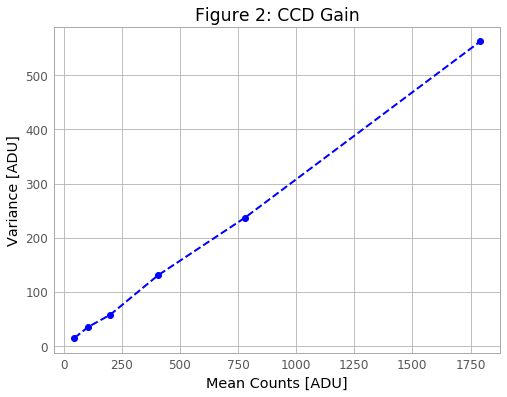

In [15]:
# Calculate the variance
variance = np.multiply(sdev_vect,sdev_vect)

plt.figure()
plt.title('Figure 2: CCD Gain')
plt.xlabel('Mean Counts [ADU]')
plt.ylabel('Variance [ADU]')
plt.plot(mu_vect,variance,'bo--', linewidth=2, markersize=6) 

## Calculate the gain using 'rise over run'
SLOPE = (variance[-1]-variance[0])/(mu_vect[-1]-mu_vect[0])
GAIN_VALUE = 1./SLOPE
print('Gain value: %.2f' % GAIN_VALUE)

Gain value [FIT]: 3.19


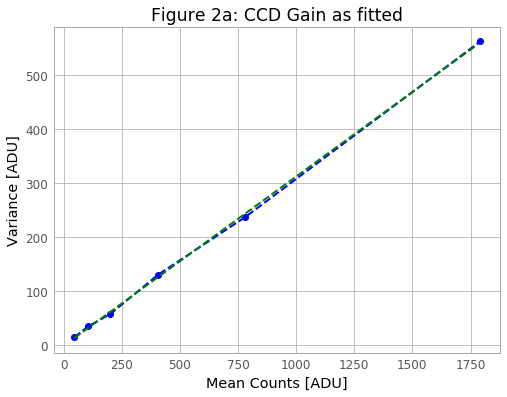

In [16]:
## We will also do a linear fit to the data to determine the gain
(SLOPE_FIT,INTERCEPT) = np.polyfit(mu_vect,variance,1)
GAIN_VALUE_FIT = 1./SLOPE_FIT
print('Gain value [FIT]: %.2f' % GAIN_VALUE_FIT)

## Also replot the CCD Gain plot with the fit overplotted
plt.figure()
plt.title('Figure 2a: CCD Gain as fitted')
plt.xlabel('Mean Counts [ADU]')
plt.ylabel('Variance [ADU]')
plt.plot(mu_vect,variance,'bo--', linewidth=2, markersize=6) 

## Use the fitted parameters to generate the fitted line
mu_gen = np.arange(mu_vect[0],mu_vect[-1],25)
var_gen = np.multiply(SLOPE_FIT,mu_gen) + INTERCEPT
plt.plot(mu_gen,var_gen,'g--', linewidth=2, markersize=6) 

### **IN THE PLOT ABOVE, YOU CAN SEE THE FIT IS NOT VERY GOOD. TRY TRIMMING OFF POINTS AT EITHER END AND SEE IF YOU CAN IMPROVE IT, AND THUS DETERMINE A BETTER GAIN VALUE**

## **Step 6: Examine the noise characteristics of the CCD**

First convert the mean and standard deviation from counts to electrons by multiplying by the _gain_. Then plot the _signal_ (N_e), versus the _noise_ (S_e). Use a log-log plot.

**NOTE** 
1. Here we are using S_e to refer to the noise, $\sigma$_e in Equation 5.4
2. You have to complete the cells above and Figure 2 in order to determine the value of _gain_.


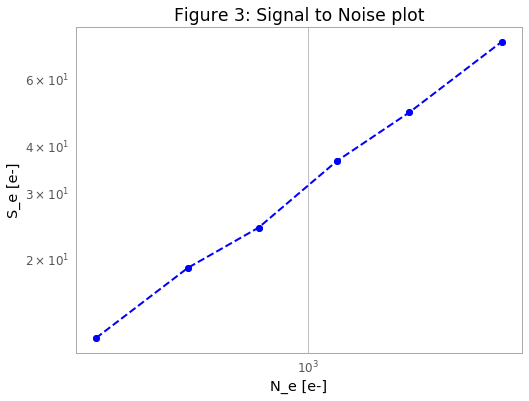

In [17]:
## ENTER THE CORRECT VALUE OF GAIN IN THE LINE BELOW BEFORE RUNNING THIS CELL
GAIN_VALUE = 3.19

N_e = np.multiply(mu_vect, GAIN_VALUE) ## THIS IS THE SIGNAL
S_e = np.multiply(sdev_vect, GAIN_VALUE) ## THIS IS THE NOISE

## create a log-log plot of signal, N_e versus noise, S_e. 
## Use the template given above for creating this plot
## Use the proper axis labels and title

plt.figure()
plt.title('Figure 3: Signal to Noise plot')
plt.xlabel('N_e [e-]')
plt.ylabel('S_e [e-]')

## THIS CREATES A SIMPLE SCATTER PLOT
plt.scatter(N_e,S_e) 

## THIS CREATES A LOG-LOG PLOT
plt.loglog(N_e,S_e,'bo--', linewidth=2, markersize=6) 

## **Question 3:**

**NOTE** YOU HAVE TO COMPLETE THE PLOT IN THE PREVIOUS CELL BEFORE YOU CAN ANSWER THIS QUESTION!

What value did you use for the gain? What are your values for N_e and S_e? (use a print statement in the cell below to print out these values neatly)


In [22]:
## USE A FOR LOOP TO PRINT OUT EACH VALUE OF N_e AND S_e SIDE BY SIDE
## USE A FORMATTED PRINT STATEMENT (SEE CODE STATEMENTS ABOVE
i=0
while i<np.size(S_e):
    print("Signal",N_e[i],"Noise",S_e[i])
    i=i+1
print("\nThe value used for the gain is 3.19")

Signal 147.880425 Noise 12.340268233283057
Signal 338.73812499999997 Noise 18.972414375465632
Signal 639.746525 Noise 24.25821310761316
Signal 1295.88965 Noise 36.47842412820899
Signal 2485.4566 Noise 49.09496019389363
Signal 5714.96475 Noise 75.6621584210859

The value used for the gain is 3.19


In [23]:
## Low signal
mu_lowSN = np.log10(N_e[0:4])
sdev_lowSN = np.log10(S_e[0:4])
(SLOPE_FIT_lowSN,INTERCEPT_lowSN) = np.polyfit(mu_lowSN,sdev_lowSN,1)
print('Slope and intercept of low SN region: %.2f %.2f' %
      (SLOPE_FIT_lowSN,INTERCEPT_lowSN))
## High signal
mu_highSN = np.log10(N_e[4:-1])
sdev_highSN = np.log10(S_e[4:-1])
(SLOPE_FIT_highSN,INTERCEPT_highSN) = np.polyfit(mu_highSN,sdev_highSN,1)
print('Slope and intercept of high SN region: %.2f %.2f' %
      (SLOPE_FIT_highSN,INTERCEPT_highSN))

Slope and intercept of low SN region: 0.49 0.03
Slope and intercept of high SN region: 0.25 0.85


/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


## **Question 4:**

What is the log-log plot of N_e versus S_e showing, qualitatively? (i.e. how does the noise change with increased signal, or, equivalently, exposure time?) 

With increased noise, increased signal occurs. With time, increased signal and noise take place.

In [24]:
Read_noise = np.sqrt(10**0.03)
print("Read noise:", Read_noise)

Read noise: 1.035142166679344


## **Step 7: Determine the Read Noise of the CCD**

#### **We will use Equation 4.4 to determine the Read Noise

Plot the variance versus the signal (with both being in numbers of electrons). The slope is the inverse of the gain, while the intercept is the square of the read noise.

**NOTE** Assume that the dark current is negligible.

Read noise: 5.4325033149243325
Gain value [FIT]: 3.19
Squared Read noise [e-]: -8.49


NameError: name 'SNR' is not defined

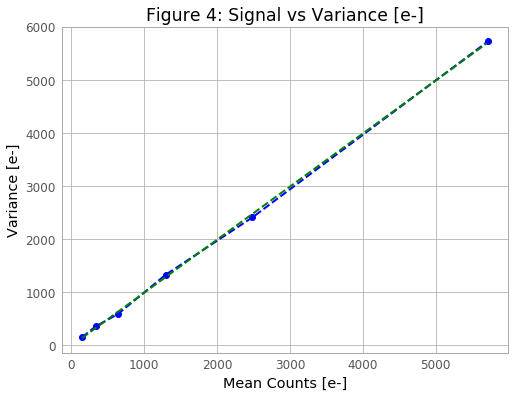

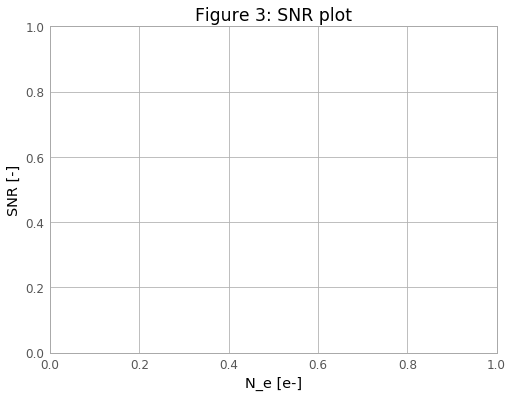

In [25]:
var_e = np.multiply(S_e,S_e)
Read_noise=np.sqrt(10**1.47)
print("Read noise:", Read_noise)

## We will also do a linear fit to the data to determine the gain
(SLOPE_FIT_e,INTERCEPT_e) = np.polyfit(N_e,var_e,1)
GAIN_VALUE_e = 1./SLOPE_FIT_e
sqrd_rd_noise_e = INTERCEPT_e
print('Gain value [FIT]: %.2f' % GAIN_VALUE_FIT)
print('Squared Read noise [e-]: %.2f' % sqrd_rd_noise_e)

## Also replot the CCD Gain plot with the fit overplotted
plt.figure()
plt.title('Figure 4: Signal vs Variance [e-]')
plt.xlabel('Mean Counts [e-]')
plt.ylabel('Variance [e-]')
plt.plot(N_e,var_e,'bo--', linewidth=2, markersize=6) 

## Use the fitted parameters to generate the fitted line
mu_gen = np.arange(N_e[0],N_e[-1],25)
var_gen = np.multiply(SLOPE_FIT_e,mu_gen) + INTERCEPT_e
plt.plot(mu_gen,var_gen,'g--', linewidth=2, markersize=6) 

## THIS CREATES A LOG-LOG PLOT
# plt.loglog(N_e,S_e,'bo--', linewidth=2, markersize=6)
plt.figure()
plt.title('Figure 3: SNR plot')
plt.xlabel('N_e [e-]')
plt.ylabel('SNR [-]')
plt.loglog(N_e,SNR,'bo--', linewidth=2, markersize=6)

## **Question 5:**

##ESTIMATE THE READ NOISE**
##Assuming that the _dark current_ is negligible, use this graph and Equation (4.4) in your lab manual to estimate the read noise. Explain your reasoning.

In [26]:
## By setting t=0, tbe 

Read_Noise=np.sqrt(10**0.03)
print("Read_Noise:",Read_Noise)

Read_Noise: 1.035142166679344


## **Step 8: Examine the relative noise (i.e. the S/N in Equation 4.5)**

**Calculate the Signal to Noise ratio, SNR** (given as S/N in Equation 4.5, and N/S in Step 5 in your manual)



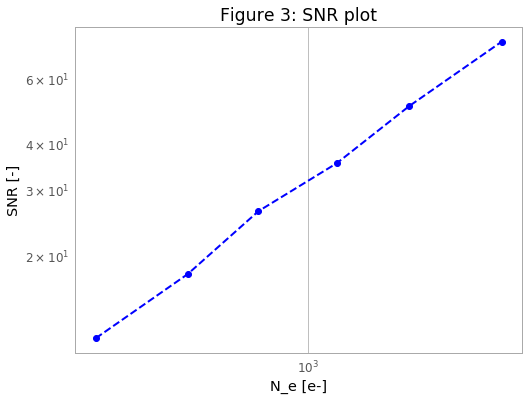

In [27]:
# calculate the signal-to-noise ratio
SNR = N_e/S_e

## Create a log-log plot of SNR versus signal, N_e. 
## Use the template given above for creating this plot
## Use the proper axis labels and title

## THIS CREATES A LOG-LOG PLOT
plt.figure()
plt.title('Figure 3: SNR plot')
plt.xlabel('N_e [e-]')
plt.ylabel('SNR [-]')
plt.loglog(N_e,SNR,'bo--', linewidth=2, markersize=6) 

## **Question 6:**

**NOTE** YOU HAVE TO COMPLETE THE PLOT IN THE PREVIOUS CELL BEFORE YOU CAN ANSWER QUESTION 5!

Qualitatively, what is this plot showing? Use a print statement (in the cell below) to print out the corresponding values of SNR and N_e . 

**ADDITIONAL QUESTION (1)** How many photons would need to hit the detector in order to get SNR = 100? Show your calculation in the cell below and explain. (HINT: Use the SNR plot and Equation 4.5)

In [28]:
## USE A FOR LOOP TO PRINT OUT EACH VALUE OF N_e AND SNR SIDE BY SIDE
## USE A FORMATTED PRINT STATEMENT (SEE CODE STATEMENTS ABOVE)
i=0
while i<np.size(SNR):
    print("signal", N_e[i], "Signal/Noise", SNR[i])
    i = i+1

signal 147.880425 Signal/Noise 11.983566499887765
signal 338.73812499999997 Signal/Noise 17.854244499215795
signal 639.746525 Signal/Noise 26.372368078472483
signal 1295.88965 Signal/Noise 35.5248254542301
signal 2485.4566 Signal/Noise 50.62549374078397
signal 5714.96475 Signal/Noise 75.53266876414307


## **Step 9: Calculate the theoretical noise**

Calculate the theoretical noise using Equation (4.4) given in your lab manual. Neglect the dark current term, Dt = 0

## **NOTE** You have to determine the value of _read noise, R_ using the plot in Figure 3.


In [29]:
## Theoretical noise using Equation 4.4

## NOTE: YOU NEED TO ENTER THE CORRECT VALUE OF READ NOISE HERE
## USE A FOR LOOP TO PRINT OUT EACH VALUE OF S_e_theo AND 
## THE MEASURED NOISE VALUE, S_e SIDE BY SIDE
## USE A FORMATTED PRINT STATEMENT (SEE CODE STATEMENTS ABOVE)

R=1.04
S_e_theor=np.sqrt(N_e+R*R)

i=0
while i<np.size(S_e_theor):
    print("Theoretical Noise",S_e_theor[i],"Measured Noise",S_e[i] ) 
    i=i+1

Theoretical Noise 12.205 Measured Noise 12.340268233283057
Theoretical Noise 18.434199874146962 Measured Noise 18.972414375465632
Theoretical Noise 25.314583247606507 Measured Noise 24.25821310761316
Theoretical Noise 36.01348705693466 Measured Noise 36.47842412820899
Theoretical Noise 49.86520029038287 Measured Noise 49.09496019389363
Theoretical Noise 75.60453921557885 Measured Noise 75.6621584210859


## **Question 7:**

Print out the theoretical noise values, S_e_theo, and the corresponding measured noise values, S_e,  in the code cell above. How do they compare to the measured values? Is there a trend with exposure time? What does this discrepancy imply? Do you think including dark current would make a difference?

Dark currents require a longer exposure time in order for us to see their effects. Taking into consideration the amount of exposure times for this lab, it was not enough to make a difference and will only be a small source of error.

## Step 10: Is this a Poisson process?

To answer this, fit a straight line to log(N_e) versus log(S_e)

In [30]:
## Let's fit a line to log(N_e) vs log(S_e)
log_Ne = np.log10(N_e)
log_Se = np.log10(S_e)
(SLOPE_SN,INTERCEPT_SN) = np.polyfit(log_Ne,log_Se,1)
print('Slope of log_SN: %.2f' % SLOPE_SN)

Slope of log_SN: 0.49


## **Question 8:**

Based on all this result, is this a Poissonian process? Explain.

It is not a Poisson distribution because the noise is not equal to the sqrt(signal).

# **ADDITIONAL QUESTIONS**

Answer the three additional questions in code cells below (INSERT NEW CODE CELLS AS NEEDED) or on a separate sheet of paper and submit it along with the marking rubric for marking.
